In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

In [2]:
# CSVファイル読み込み
df = pd.read_csv('new_mushrooms.csv')

In [3]:
# Unnamed が邪魔なので削除する
drop_columns = ['Unnamed: 0']
df = df.drop(drop_columns, axis=1)

In [4]:
# データを訓練データ、テストデータに分割する
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size = 0.3)
# indexをリセットする
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
print("訓練データ : \n",train_df['class'].value_counts())
print("テストデータ : \n",test_df['class'].value_counts())
# 特徴として使うデータとラベルとして使うデータに分ける
X_train = np.array(train_df.drop('class', axis=1).values).astype(np.float32)
y_train = np.array(train_df['class'].values).astype(np.float32)

X_test = np.array(test_df.drop('class', axis=1).values).astype(np.float32)
y_test = np.array(test_df['class'].values).astype(np.float32)

y_train = y_train.reshape(-1,1)
y_test =y_test.reshape(-1,1)

訓練データ : 
 0    2966
1    2720
Name: class, dtype: int64
テストデータ : 
 0    1242
1    1196
Name: class, dtype: int64


In [5]:
# 入力層
X = tf.placeholder(tf.float32, shape=[None, 6], name="input")
t = tf.placeholder(tf.float32, shape=[None, 1])
# パラメータ1
stddev = np.sqrt(2.0 / 6)
W1 = tf.Variable(tf.truncated_normal([6,8], stddev=stddev))
b1 = tf.Variable(tf.constant(0.1, shape=[1]))

# パラメータ2
stddev = np.sqrt(2.0 / 8)
W2 = tf.Variable(tf.truncated_normal([8,1], stddev=stddev))
b2 = tf.Variable(tf.constant(0.1, shape=[1]))

layer1 = tf.matmul(X,W1) + b1
layer2 = tf.matmul(layer1,W2) + b2

p = tf.nn.sigmoid(layer2,name="output")
# 損失関数
loss = tf.reduce_mean(tf.square(p - t))
# 学習アルゴリズム
optimizer = tf.train.GradientDescentOptimizer(0.01)
train_step = optimizer.minimize(loss)
# 精度
correct_prediction = tf.equal(tf.sign(p-0.5), tf.sign(t-0.5))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [6]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

batch_size = 30
for i in range(300):
    batch_mask = np.random.choice(X_train.shape[0], batch_size)
    x_batch = X_train[batch_mask]
    y_batch = y_train[batch_mask]
    sess.run(train_step,feed_dict={X: x_batch, t: y_batch})
    if i % 100 == 0:
        train_acc, train_loss = sess.run([accuracy,loss], feed_dict={X: X_train, t: y_train})
        test_acc, test_loss = sess.run([accuracy,loss], feed_dict={X: X_test, t: y_test})
        print("[Train] step: %d, loss: %f, acc: %f, [Test] loss: %f, acc : %f" % (i, train_loss, train_acc,test_loss,test_acc))

[Train] step: 0, loss: 0.474276, acc: 0.521632, [Test] loss: 0.486439, acc : 0.509434
[Train] step: 100, loss: 0.464342, acc: 0.521632, [Test] loss: 0.476400, acc : 0.509434
[Train] step: 200, loss: 0.311857, acc: 0.678333, [Test] loss: 0.319457, acc : 0.672272


混同行列を作成する             
このCSVファイルでは食用キノコの時は値が 1 , 毒キノコなら値は 0　となっている。           

混同行列は以下のように定義される          
$
  混同行列 = \left(
    \begin{array}{cc}
      真陽性(tp)  & 偽陽性(fp) \\
      偽陰性(fn) & 真陰性(tn) \\
    \end{array}
  \right)
$

In [7]:
# 混同行列を作成する
# 食用キノコなら 1 毒キノコなら 0
conf_mat = np.array([[0.,0.],[0.,0.]])
pred = sess.run(p,feed_dict={X: X_test}).reshape(-1,)

for i in range(0,(X_test).shape[0]):
    
    # 真陰性(食用と判断して害がなかった場合)
    if (y_test[i] == 1) and (pred[i] >= 0.5):
        conf_mat[1,1] += 1.
        
    # 偽陰性(食用と予測したが毒キノコだった場合)
    elif (y_test[i] == 0) and (pred[i] >= 0.5):
        conf_mat[0,1] += 1.
    
    # 偽陽性(毒キノコと予測したが食用キノコだった場合)
    elif (y_test[i] == 1) and (pred[i] < 0.5):
        conf_mat[1,0] += 1.
    
    # 真陽性(毒キノコとどちらも判断して警戒した時):
    elif (y_test[i] == 0) and (pred[i] < 0.5):
        conf_mat[0,0] += 1.
        
conf_mat

array([[ 768.,  474.],
       [ 464.,  732.]])

期待利益を求める         
前提として各クラスの組み合わせによる利益やコストの値を定義し、損益行列を定義する必要がある。            

$
  損益行列 = \left(
    \begin{array}{ccc}
     　tp時の利益b(\boldsymbol{Y},\boldsymbol{p})  & fp時のコストc(\boldsymbol{Y},\boldsymbol{n}) & \\
      fn時のコストc(\boldsymbol{N},\boldsymbol{p}) & tn時の利益b(\boldsymbol{N},\boldsymbol{n})  &\\
    \end{array}
  \right)
$       

(Y,p)などは行が予測値、列が実際の値とする     

In [8]:
# 損益行列を定義する            
# tn時の利益を 10ドル       
# fn時のコストを -5ドル     
# tp,tp時の利益、コストを 0　とする        

cost_benefit_mat = np.array([[0.,0.],[-5.,10.]])

cost_benefit_mat

array([[  0.,   0.],
       [ -5.,  10.]])

期待利益を計算する         

$
期待利益 = p(\boldsymbol{Y},\boldsymbol{p})\cdot b(\boldsymbol{Y},\boldsymbol{p})
+p(\boldsymbol{N},\boldsymbol{p})\cdot b(\boldsymbol{N},\boldsymbol{p})
+p(\boldsymbol{N},\boldsymbol{n})\cdot b(\boldsymbol{N},\boldsymbol{n})
+p(\boldsymbol{Y},\boldsymbol{n})\cdot b(\boldsymbol{Y},\boldsymbol{n})
$   

$
p(x,y) = p(y) \cdot p(x|y)　より
$   

$
期待利益 = p(\boldsymbol{p})\cdot(p(\boldsymbol{Y}\mid \boldsymbol{p})\cdot b(\boldsymbol{Y},\boldsymbol{p})
+p(\boldsymbol{N}\mid \boldsymbol{p})\cdot c(\boldsymbol{N},\boldsymbol{p}))
+p(\boldsymbol{n})\cdot(p(\boldsymbol{N}\mid \boldsymbol{n})\cdot b(\boldsymbol{N},\boldsymbol{n})
+p(\boldsymbol{Y}\mid \boldsymbol{n})\cdot c(\boldsymbol{Y},\boldsymbol{n}))
$      

p(p),p(n)はクラスの事前確率であり、陽性と陰性がそれぞれ出現する確率を表す     
p(Y | p)などは混同行列を割合へ変換することで求めることができる     
つまり        
$
期待利益 = p(\boldsymbol{p})\cdot(tp率\cdot b(\boldsymbol{Y},\boldsymbol{p})
+fn率\cdot c(\boldsymbol{N},\boldsymbol{p}))
+p(\boldsymbol{n})\cdot(tn率\cdot b(\boldsymbol{N},\boldsymbol{n})
+fp率\cdot c(\boldsymbol{Y},\boldsymbol{n}))
$と表記できる     

In [9]:
# クラスの事前確率を求める

T = X_test.shape[0]
positive_num = conf_mat[0,0] + conf_mat[1,0]
negative_num = conf_mat[0,1] + conf_mat[1,1]

prob_p = positive_num / T
prob_n =1 - prob_p

prob_tp = conf_mat[0,0] / positive_num
prob_fp = conf_mat[0,1] / negative_num
prob_fn = 1 - prob_tp
prob_tn = 1 - prob_fp

expect_profit = prob_p*(prob_tp*cost_benefit_mat[0,0] + prob_fn*cost_benefit_mat[1,0])+prob_n*(prob_tn*cost_benefit_mat[1,1] + prob_fp*cost_benefit_mat[0,1])
    
print("事前確率 p(p) : "+str(prob_p))
print("事前確率 p(n) : "+str(prob_n))
print("tp率 : "+str(prob_tp))
print("fp率 : "+str(prob_fp))
print("tn率 : "+str(prob_tn))
print("fn率 : "+str(prob_fn))
print("期待利益 : "+str(expect_profit))

事前確率 p(p) : 0.505332239541
事前確率 p(n) : 0.494667760459
tp率 : 0.623376623377
fp率 : 0.393034825871
tn率 : 0.606965174129
fn率 : 0.376623376623
期待利益 : 2.05086136177


In [10]:
# 利益曲線を描く
# 予測と実際の値の組を作成し、予測値の昇順にソートする
idx = pred.copy()
idx = np.argsort(idx)[::-1]
score_list = []
for i in idx:
    score_list.append((y_test[i][0],pred[i]))

In [11]:
conf_mat2 = np.array([[conf_mat[0,0]+conf_mat[1,0],conf_mat[0,1]+conf_mat[1,1]],[0.,0.]])
print(conf_mat2)

profit_curve = []
t = 0
# 初期値を追加
profit_curve.append(0)
for l,v in score_list:
    
    # 真陰性(食用と判断して害がなかった場合)
    if(v >= 0.5 and l==1):
        t += cost_benefit_mat[1,1]
        if(conf_mat[0,1]+conf_mat[1,1] > conf_mat2[1,1]):
            conf_mat2[0,1] -= 1.
            conf_mat2[1,1] += 1.
    # 偽陰性(食用と判断したが毒キノコだった場合)
    elif(v >= 0.5 and l==0):
        t += cost_benefit_mat[1,0]
        if(conf_mat[0,0]+conf_mat[1,0] > conf_mat2[1,0]):
            conf_mat2[0,0] -= 1.
            conf_mat2[1,0] += 1.
    # スコアが0.5未満の場合は毒キノコと判定し、利益には影響しないのでループを終える
    elif(v < 0.5):
        break
    
    profit_curve.append(t)
    
print(conf_mat2)

[[ 1232.  1206.]
 [    0.     0.]]
[[ 758.  474.]
 [ 474.  732.]]


利益曲線を描く

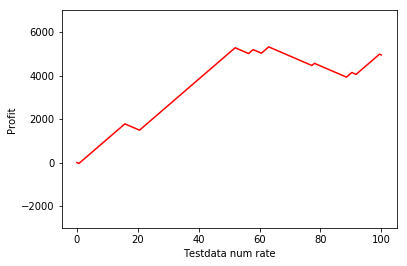

In [12]:
plt.xlabel('Testdata num rate')
plt.ylabel('Profit')
plt.ylim([-3000,7000])
axis_x = np.linspace(0,100,len(profit_curve))
plt.plot(axis_x,profit_curve,"r-")

受信者動作特性(ROC)グラフを描く

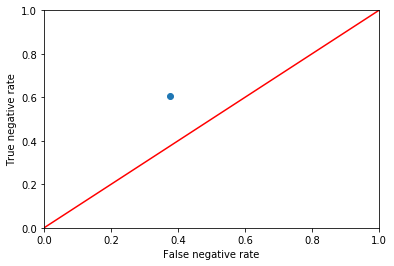

In [13]:
plt.ylim([0,1])
plt.xlim([0,1])
plt.xlabel('False negative rate')
plt.ylabel('True negative rate')

axis_x = np.linspace(0,1,50)
line_y = axis_x
plt.plot([prob_fn], [prob_tn], 'o')
plt.plot(axis_x,line_y,"r-")

テストデータの数を増やすごとにROC曲線がどのように変化するか確認する

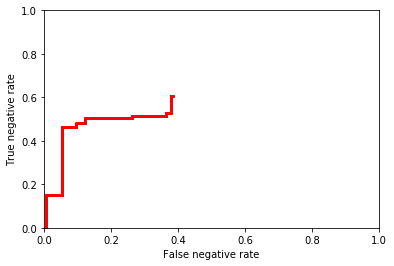

In [14]:
conf_mat2 = np.array([[conf_mat[0,0]+conf_mat[1,0],conf_mat[0,1]+conf_mat[1,1]],[0.,0.]])

prob_fn2 = 0
prob_tn2 = 0

plt.ylim([0,1])
plt.xlim([0,1])
plt.xlabel('False negative rate')
plt.ylabel('True negative rate')

for l,v in score_list:
    
    # 真陰性(食用と判断して害がなかった場合)
    if(v >= 0.5 and l==1):
        if(conf_mat[0,1]+conf_mat[1,1] > conf_mat2[1,1]):
            conf_mat2[0,1] -= 1.
            conf_mat2[1,1] += 1.
        
        prob_fn2 = conf_mat2[1,0] / positive_num
        prob_tn2 = conf_mat2[1,1] / negative_num
        plt.plot([prob_fn2], [prob_tn2], 'ro', markersize=2)
    # 偽陰性(食用と判断したが毒キノコだった場合)
    elif(v >= 0.5 and l==0):
        if(conf_mat[0,0]+conf_mat[1,0] > conf_mat2[1,0]):
            conf_mat2[0,0] -= 1.
            conf_mat2[1,0] += 1.
        
        prob_fn2 = conf_mat2[1,0] / positive_num
        prob_tn2 = conf_mat2[1,1] / negative_num
        plt.plot([prob_fn2], [prob_tn2], 'ro', markersize=2)
    # スコアが0.5未満の場合は毒キノコと判定し、利益には影響しないのでループを終える
    elif(v < 0.5):
        break

累積反応曲線を描く

[[ 758.  474.]
 [ 474.  732.]]


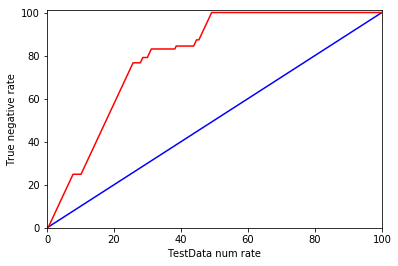

In [15]:
# 真陰性の割合を求める
tn2_rate = 0
com_res_curve = []
plt.xlabel('TestData num rate')
plt.ylabel('True negative rate')

neg_count = 0.
for l,v in score_list:
    # 真陰性(食用と判断して害がなかった場合)
    if(v >= 0.5 and l==1):
        neg_count += 1.
        tn2_rate = (neg_count / conf_mat[1,1])*100
        com_res_curve.append(tn2_rate)
    # 偽陰性(食用と判断したが毒キノコだった場合)
    elif(v >= 0.5 and l==0):
        tn2_rate = (neg_count / conf_mat[1,1])*100
        com_res_curve.append(tn2_rate)
    elif(v < 0.5):
        com_res_curve.append(tn2_rate)
print(conf_mat2)

plt.ylim([0,101])
plt.xlim([0,100])
axis_x = np.linspace(0,100,len(com_res_curve))
line_y = axis_x
plt.plot(axis_x,line_y,"b-")
plt.plot(axis_x,com_res_curve,"r-")

リフト曲線を描く

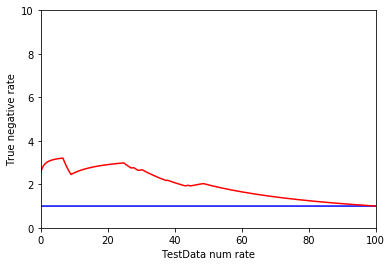

In [16]:
lift_curve = []
plt.xlabel('TestData num rate')
plt.ylabel('True negative rate')

# 最初は0が多いので適当な場所から開始する
for i in range(30,len(com_res_curve)):
    lift_curve.append(com_res_curve[i]/line_y[i])

plt.ylim([0,10])
plt.xlim([0,100])
axis_x = np.linspace(0,100,len(lift_curve))
line_y2 = np.ones((len(lift_curve),))
plt.plot(axis_x,line_y2,"b-")
plt.plot(axis_x,lift_curve,"r-")